In [35]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import copy 
import os

import torch
import torchvision

import pandas as pd
import sklearn

from torchvision import transforms, utils
import PIL
from torch.autograd import Variable


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=bf6dc201d8128c506bfa16a4951535d9725d66eecf77e7da045d74987558d8c9
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p data
!cp '/content/drive/Shareddrives/UCI CS175 Team23/training_solutions_rev1.csv' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_training_rev1.zip' -d ./data/

In [36]:
!ls data

images_test_rev1      images_training_rev1
images_test_rev1.zip  training_solutions_rev1.csv


In [6]:
training_data_path = '/content/data/images_training_rev1'
solution_path = '/content/data/training_solutions_rev1.csv'

In [7]:
df = pd.read_csv(solution_path)

In [22]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


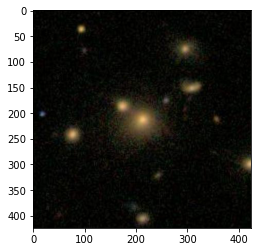

In [123]:
plt.imshow(plt.imread(training_data_path + "/" + str(df["GalaxyID"][7]) + ".jpg"))

In [37]:
# reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class GalaxyDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, usr_root_dir, usr_transforms=None):
    self.solution = pd.read_csv(solution_path)
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms

  def __len__(self):
    return len(self.solution)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = self.root_dir + "/" + str(self.solution.iloc[idx,0]) + ".jpg"
    id = self.solution.iloc[idx,0]
    #image = plt.imread(img_name).T
    image = PIL.Image.open((img_name))
    image = self.transforms(image)
    proba = self.solution.iloc[idx,1:].to_numpy()
    #image = np.moveaxis(image.numpy()*255, 0, -1).astype("uint8")
    return  image, proba, id

In [38]:
galaxy_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(int(224/2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(50),
    transforms.ToTensor()
    ])

tri_full = GalaxyDataset(solution_path, training_data_path, galaxy_transform)

In [39]:
def show_image(sample_image):
  example_img = np.moveaxis(sample_image.numpy()*255, 0, -1).astype("uint8")
  plt.imshow(example_img)


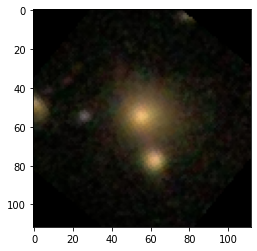

In [124]:
#show_image(tri_full[np.random.choice(40000)][0])
show_image(tri_full[7][0])

In [47]:
a, b = torch.utils.data.random_split(tri_full, [43104, 18474], torch.Generator().manual_seed(1234))

loader_train = torch.utils.data.DataLoader(a, batch_size=64)
loader_valid = torch.utils.data.DataLoader(b)

loader_train_full = torch.utils.data.DataLoader(tri_full, batch_size=200)

gpu_dtype = torch.cuda.FloatTensor

In [48]:
def custom_train(model, loader, loss_fn, optimizer, num_epochs = 1):
    epoch_log = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        t_log = []
        for t, (x, y, _) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype))
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            if (t + 1) % 500 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
            t_log.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_log.append(max(t_log))   
    
    fig = plt.figure(figsize=(7,7))
    plt.plot(epoch_log)
    plt.ylim(0, 3)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return epoch_log

In [49]:
def check_accuracy(model, loader, num_sample):
    model.eval() 
    #temp = torch.ones([1,37]).type(gpu_dtype)
    temp = 0
    count = 0
    with torch.no_grad():
      for x, y, id in loader:
          # 
          x_var = Variable(x.type(gpu_dtype))
          y_var = Variable(y.type(gpu_dtype))
          
          scores = model(x_var)
          scores[scores < 0] = 0
          diff = y_var - scores
          

          # print(scores)
          # print(y_var)
          # print(diff , "\n")
          #temp += torch.square(diff)
          temp += torch.sqrt(torch.mean(torch.square(diff)))
          #temp += diff
          count += 1
          if num_sample == count:
            break
    print(temp / num_sample)
    #print(torch.sqrt(torch.mean(torch.div(temp, len(loader)))))
    print( temp / len(loader) )
    #print(torch.sqrt(torch.mean(torch.square(torch.div(temp, len(loader))))))
  

In [50]:
!cp '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' -d ./data/
!ls data

images_test_rev1      images_training_rev1
images_test_rev1.zip  training_solutions_rev1.csv


In [51]:
class GalaxyTestDataset(torch.utils.data.Dataset):
  def __init__(self, usr_root_dir, usr_transforms=None):
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms
    self.images_path = os.listdir(usr_root_dir)

  def __len__(self):
    return len(self.images_path)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    self.images_path.sort()
    file_paths = self.images_path
    img_name = self.root_dir + "/" + file_paths[idx]
    id = int(file_paths[idx].split(".")[0])

    image = PIL.Image.open((img_name))
    image = self.transforms(image)

    return  image, id

In [116]:
def write_prediction(model, loader, output_name, header_list):
  model.eval() 
  num_sample = len(loader)

  numpy_temp = np.ones((num_sample, 38))

  count = 0
  with torch.no_grad():
    for x, id in loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        scores[scores < 0] = 0
        scores[scores > 1] = 1
        
        scores_numpy = scores.cpu().detach().numpy()

        
        numpy_temp[count][0] = id
        numpy_temp[count][1:] = scores_numpy

        count += 1

        if count == 10:
          break

  something = pd.DataFrame(numpy_temp)

  something.columns = header_list
  something = something.astype({"GalaxyID": "int64"})

  print(something.head(10))

  #something.to_csv(output_name,  index=False)

  return numpy_temp

In [54]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512, 37)
resnet.cuda()
opt = optim.SGD(resnet.parameters(), lr = 0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [90]:
resnet.load_state_dict(torch.load('resnet18-full-best-state.pt')["model"])
opt.load_state_dict(torch.load('resnet18-full-best-state.pt')["optim"])

In [ ]:
resnet.state_dict()

Starting epoch 1 / 10
Starting epoch 2 / 10
Starting epoch 3 / 10
Starting epoch 4 / 10
Starting epoch 5 / 10
Starting epoch 6 / 10
Starting epoch 7 / 10
Starting epoch 8 / 10
Starting epoch 9 / 10
Starting epoch 10 / 10
CPU times: user 34min 10s, sys: 26.1 s, total: 34min 37s
Wall time: 34min 30s


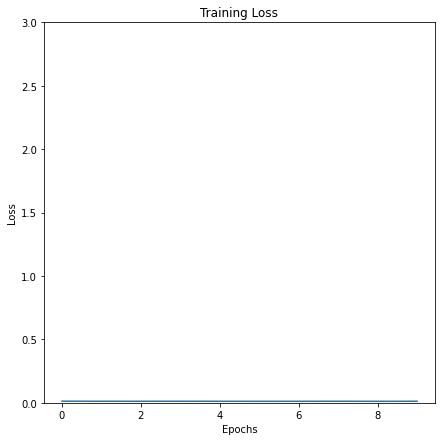

In [93]:
loss = nn.MSELoss().type(gpu_dtype)
%time resnet_training_loss = custom_train(resnet, loader_train_full ,loss, opt, 10)
# CPU times: user 34min 7s, 0.097
# CPU times: user 34min 8s, 0.092
# CPU times: user 34min 10s, 0.090

In [121]:
check_accuracy(resnet, loader_valid, 20000)

tensor(0.0820, device='cuda:0')
tensor(0.0888, device='cuda:0')


In [ ]:
resnet.state_dict()

In [118]:
test_data_path = '/content/data/images_test_rev1'
test_transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.Resize(int(224/2)),
    transforms.ToTensor()
    ])
test_full = GalaxyTestDataset(test_data_path, test_transform)
loader_test = torch.utils.data.DataLoader(test_full)

In [119]:
%time write_prediction(resnet, loader_test, "resnet_full-best2.csv", df.columns.values)

   GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0    100018  0.529693  0.459850  ...   0.000000   0.000000   0.042817
1    100037  0.378437  0.585338  ...   0.000000   0.000000   0.000000
2    100042  0.505008  0.450166  ...   0.000000   0.000000   0.006211
3    100052  0.689458  0.265554  ...   0.000000   0.000000   0.016177
4    100056  0.502228  0.460336  ...   0.000000   0.000000   0.000000
5    100058  0.468486  0.487685  ...   0.015893   0.002693   0.072182
6    100062  0.503396  0.463062  ...   0.014133   0.006804   0.000000
7    100065  0.548384  0.413397  ...   0.004217   0.013041   0.013069
8    100071  0.371210  0.618098  ...   0.003771   0.000000   0.085357
9    100076  0.352528  0.604003  ...   0.022759   0.032479   0.075336

[10 rows x 38 columns]
CPU times: user 187 ms, sys: 19 ms, total: 206 ms
Wall time: 207 ms


array([[1.00018000e+05, 5.29692650e-01, 4.59850371e-01, ...,
        0.00000000e+00, 0.00000000e+00, 4.28170227e-02],
       [1.00037000e+05, 3.78437430e-01, 5.85338414e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00042000e+05, 5.05008340e-01, 4.50166464e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.21086359e-03],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [113]:
!cp resnet_full-best2.csv '/content/drive/Shareddrives/UCI CS175 Team23'

In [ ]:
resnet.state_dict()

In [120]:
torch.save(resnet, "resnet18-full-best2.pt")
torch.save({"model": resnet.state_dict(),
            "optim": opt.state_dict()},
           "resnet18-full-best-state2.pt")

In [86]:
!cp resnet18-full-best.pt '/content/drive/Shareddrives/UCI CS175 Team23'
!cp resnet18-best-state.pt '/content/drive/Shareddrives/UCI CS175 Team23'

cp: cannot stat 'resnet18-best-state.pt': No such file or directory


In [37]:
loaded_model = torch.load('/content/drive/Shareddrives/UCI CS175 Team23/effnet.pt' )

In [ ]:
loaded_model.state_dict()

In [ ]:
check_accuracy(loaded_model, loader_valid, 10)

In [ ]:
%time test_solution = write_prediction(loaded_model, loader_test, "numpy_temp.csv",  df.columns.values)

   GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0    999996  0.662544  0.312697  ...    0.00267    0.00155   0.031011
1         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
2         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
3         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
4         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000

[5 rows x 38 columns]
CPU times: user 30min 36s, sys: 11.8 s, total: 30min 47s
Wall time: 30min 41s


In [ ]:
!cp numpy_temp.csv "/content/drive/Shareddrives/UCI CS175 Team23/"

In [ ]:
!cp effnet.pt "/content/drive/Shareddrives/UCI CS175 Team23/"

In [ ]:
fixed_model_base = nn.Sequential( # You fill this in!
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2, 2),

                    nn.Flatten(),
                    nn.Linear(5408, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 37)
                )

fixed_model_gpu = fixed_model_base.type(torch.cuda.FloatTensor)